# Aligning Deep Exposures of Sparse Fields

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

# Introduction


This notebook demonstrates aligning long exposures which have relatively few stars and a large number of cosmic rays. It is based on the example described in the ISR linked here ([ACS ISR 2015-04: Basic Use of SExtractor Catalogs With TweakReg - I](http://www.stsci.edu/hst/acs/documents/isrs/isr1504.pdf)), but uses a much simpler methodology.


Rather than making use of external software (e.g. [SExtractor](http://www.astromatic.net/software/sextractor)) and going through the extra steps to create 'cosmic-ray cleaned' images for each visit, this notebook demonstrates new features in TweakReg designed to mitigate false detections.

TweakReg’s source finding task `imagefind` now includes parameters to exclude false detections and allow the software to more easily solve for the image offsets using matched sources lists. For example, `dqbits` is a list of DQ flag values to include as 'good' or to exclude as 'bad' before generating and matching source lists. For ACS/WFC, setting `dqbits=-16` will mask hot pixels flagged by the instrument team, eliminating a common problem where TweakReg locks onto hot pixels and solves for the dither pattern. This can occur when users set the detection threshold value too low and hot pixels outnumber astronomical sources. Other new parameters allow selection for sharpness and roundness, which give users better control over source selection criteria and the mitigation of artifacts. More details on imagefindpars options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/deployment/imagefindpars.html).

In [1]:
from astropy.table import Table
from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
import glob
import matplotlib.pyplot as plt
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Download the Data

The data in this example are comprised of 4 exposures in the F814W filter, all from Visit 0X of HST program 10092. Each exposure was dithered by ~60 pixels along the y-axis in order to obtain coverage in the area of the CCD chip gap. The X and Y dithers are given in arcseconds by the `POSTARG1` and `POSTARG2` keywords recorded in the image header.

The following commands query MAST, download the calibrated, CTE-corrected FLC files, and place them in the same 'working' directory as this notebook. 

In [2]:
# Query MAST for the F814W files.
science_list = Observations.query_criteria(proposal_id='10092', filters='F814W', obs_id='j8xi0x*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLC'])

science_files = glob.glob('science/mastDownload/HST/*/*fits')
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './'+root)
shutil.rmtree('science/')

# 2. Inspect the image headers

In [3]:
collect = ImageFileCollection('./',
                              keywords=["asn_id", "detector", "filter2", "exptime", "postarg1", "postarg2"],
                              glob_include="*flc.fits", ext=0)
out_table = collect.summary
out_table

file,asn_id,detector,filter2,exptime,postarg1,postarg2
str44,str9,str3,str5,float64,float64,float64
hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits,J8XI0X010,WFC,F814W,507.0,0.062,-3.0518
hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits,J8XI0X010,WFC,F814W,507.0,0.31,0.023747
hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits,J8XI0X010,WFC,F814W,507.0,-0.062,3.0518
hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits,J8XI0X010,WFC,F814W,507.0,0.186,6.127347
j8xi0xs0q_flc.fits,J8XI0X010,WFC,F814W,507.0,0.062,-3.0518
j8xi0xs3q_flc.fits,J8XI0X010,WFC,F814W,507.0,0.31,0.023747
j8xi0xs6q_flc.fits,J8XI0X010,WFC,F814W,507.0,-0.062,3.0518
j8xi0xsaq_flc.fits,J8XI0X010,WFC,F814W,507.0,0.186,6.127347


# 3. TweakReg Alignment 

Use TweakReg to align the FLC frames based on sources in the image. The provided input list (`input_flc.list`) is used to align the frames in the specified order with `j8xi0xsaq_flc.fits` as the reference image. The parameter `conv_width` specifies the convolution kernel width in pixels, with recommended values ~2x the PSF FWHM for detecting point sources in the FLC frame. For ACS/WFC & WFC3/UVIS, this parameter is typically set to 3.5 pixels and for WFC3/IR to 2.5 pixels, but the value can be increased in order to use compact objects such as small galaxies for alignment.

## 3a. Use 'default' parameters (Test1)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 18:32:21.692 (03/10/2023) 


TweakReg Version 3.5.1 started at: 18:32:21.692 (03/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.26.0 


numpy Version -> 1.26.0 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakr

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:32:21.882 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:32:21.882 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173600
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:22.685 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 8432 objects.


     Found 8432 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:32:22.807 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:32:22.807 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.010726
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:23.579 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 8580 objects.


     Found 8580 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 17012


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 17012


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:32:24.315 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:32:24.315 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.091646
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:25.050 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 6202 objects.


     Found 6202 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:32:25.159 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:32:25.159 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.106821
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:25.797 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 6118 objects.


     Found 6118 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 12320


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 12320


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:32:26.929 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:32:26.929 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173861
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:27.531 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 4676 objects.


     Found 4676 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:32:27.628 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:32:27.628 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.040191
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:28.325 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 4793 objects.


     Found 4793 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 9469


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 9469


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:32:29.232 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:32:29.232 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.632135
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:29.90 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 4919 objects.


     Found 4919 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:32:30.007 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:32:30.007 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.651426
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:30.621 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 5225 objects.


     Found 5225 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 10144


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 10144


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.4
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.1058, -0.2513 with significance of 17.35 and 378 matches


Found initial X and Y shifts of -0.1058, -0.2513 with significance of 17.35 and 378 matches


INFO:drizzlepac.imgclasses:Found 102 matches for j8xi0xs6q_flc.fits...


Found 102 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1263  YSH: -0.1598    ROT: 359.9994312    SCALE: 0.999925


XSH: -0.1263  YSH: -0.1598    ROT: 359.9994312    SCALE: 0.999925


INFO:drizzlepac.imgclasses:FIT XRMS: 0.37       FIT YRMS: 0.38   


FIT XRMS: 0.37       FIT YRMS: 0.38   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.53       FIT MAE: 0.46   


FIT RMSE: 0.53       FIT MAE: 0.46   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.1e-06 (deg)   RMS_DEC: 4.1e-06 (deg)


RMS_RA: 6.1e-06 (deg)   RMS_DEC: 4.1e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  102  objects.


Final solution based on  102  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 102


Total # points: 102


INFO:drizzlepac.tweakutils:# of points after clipping: 102


# of points after clipping: 102


INFO:drizzlepac.tweakutils:Total # points: 102


Total # points: 102


INFO:drizzlepac.tweakutils:# of points after clipping: 102


# of points after clipping: 102


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.3663, -0.04756 with significance of 16.69 and 305 matches


Found initial X and Y shifts of -0.3663, -0.04756 with significance of 16.69 and 305 matches


INFO:drizzlepac.imgclasses:Found 79 matches for j8xi0xs3q_flc.fits...


Found 79 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2238  YSH: 0.0805    ROT: 359.9984056    SCALE: 1.000031


XSH: -0.2238  YSH: 0.0805    ROT: 359.9984056    SCALE: 1.000031


INFO:drizzlepac.imgclasses:FIT XRMS: 0.44       FIT YRMS: 0.33   


FIT XRMS: 0.44       FIT YRMS: 0.33   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.55       FIT MAE: 0.48   


FIT RMSE: 0.55       FIT MAE: 0.48   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.6e-06 (deg)   RMS_DEC: 5.2e-06 (deg)


RMS_RA: 5.6e-06 (deg)   RMS_DEC: 5.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  79  objects.


Final solution based on  79  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 79


Total # points: 79


INFO:drizzlepac.tweakutils:# of points after clipping: 79


# of points after clipping: 79


INFO:drizzlepac.tweakutils:Total # points: 79


Total # points: 79


INFO:drizzlepac.tweakutils:# of points after clipping: 79


# of points after clipping: 79


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.294, -0.06495 with significance of 15.18 and 308 matches


Found initial X and Y shifts of 0.294, -0.06495 with significance of 15.18 and 308 matches


INFO:drizzlepac.imgclasses:Found 78 matches for j8xi0xs0q_flc.fits...


Found 78 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2007  YSH: 0.1344    ROT: 0.0003832140447    SCALE: 0.999994


XSH: 0.2007  YSH: 0.1344    ROT: 0.0003832140447    SCALE: 0.999994


INFO:drizzlepac.imgclasses:FIT XRMS: 0.39       FIT YRMS: 0.29   


FIT XRMS: 0.39       FIT YRMS: 0.29   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.48       FIT MAE: 0.39   


FIT RMSE: 0.48       FIT MAE: 0.39   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.9e-06 (deg)   RMS_DEC: 4.6e-06 (deg)


RMS_RA: 4.9e-06 (deg)   RMS_DEC: 4.6e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  76  objects.


Final solution based on  76  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 76


Total # points: 76


INFO:drizzlepac.tweakutils:# of points after clipping: 76


# of points after clipping: 76


INFO:drizzlepac.tweakutils:Total # points: 76


Total # points: 76


INFO:drizzlepac.tweakutils:# of points after clipping: 76


# of points after clipping: 76


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test1.txt


Writing out shiftfile : shift814_flc_test1.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


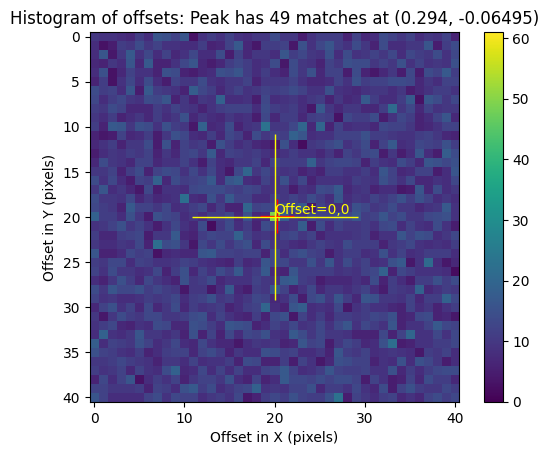

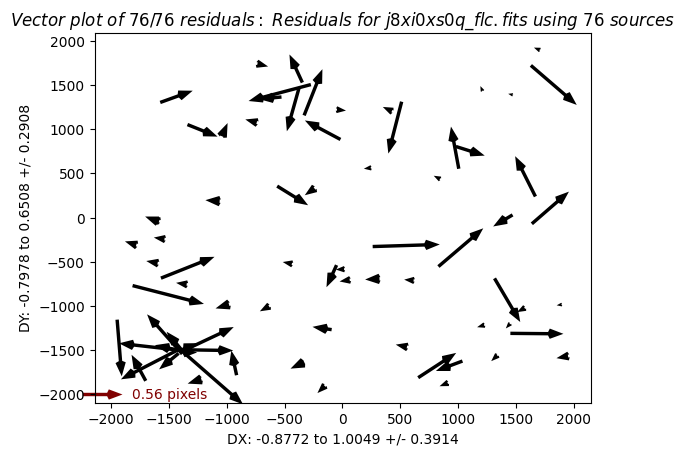

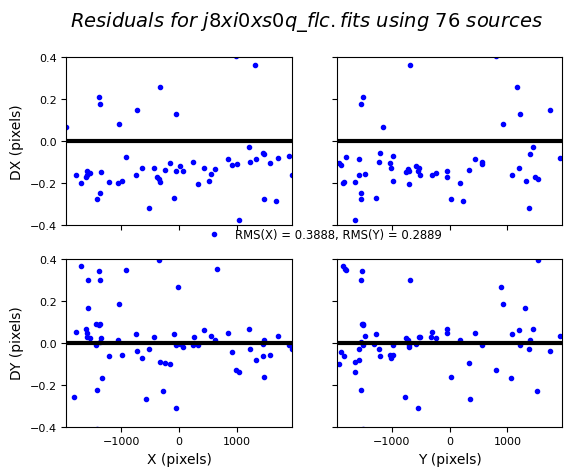

In [4]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100,'conv_width': 3.5},
                  shiftfile=True, outshifts='shift814_flc_test1.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

In [5]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test1_{}'.format(png)))
    os.rename(path, new_path)

To verify that TweakReg has found a good fit, it is important to inspect the fit residuals. Below are the dx,dy residuals for each FLC file with respect to the reference image `j8xi0xsaq_flc.fits`. TweakReg finds >100 matches per frame, but the RMS of the fit residuals is quite large, ~0.7 pixels, and the points are not nicely clustered around dx,dy=0.0, as expected for a good fit.

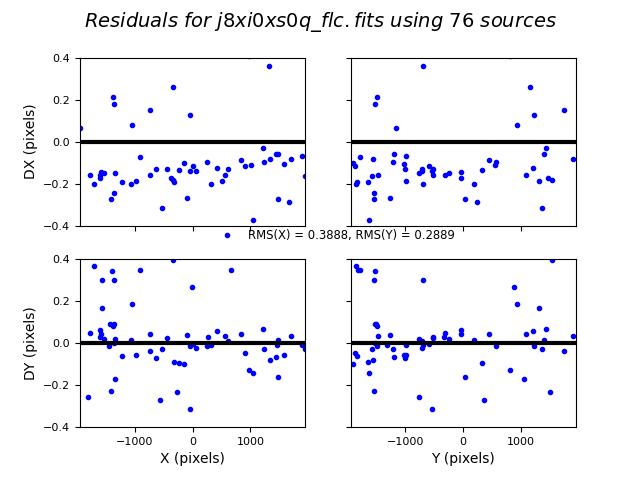

In [6]:
Image(filename='test1_residuals_j8xi0xs0q_flc.png')

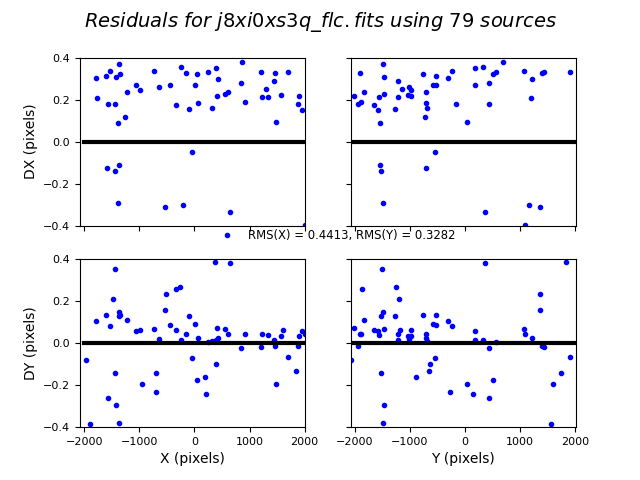

In [7]:
Image(filename='test1_residuals_j8xi0xs3q_flc.png')

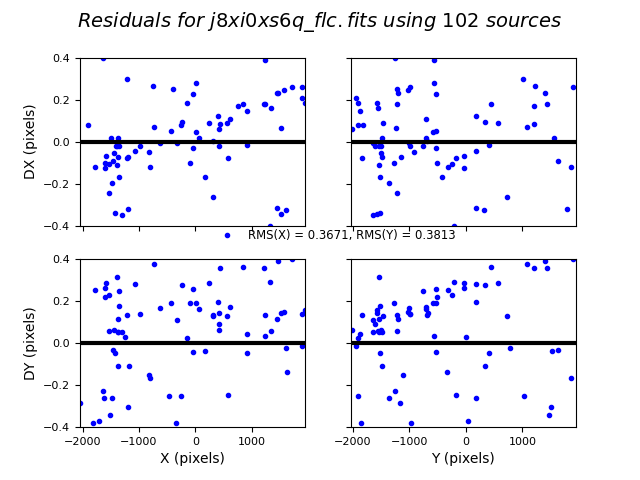

In [8]:
Image(filename='test1_residuals_j8xi0xs6q_flc.png')

In [9]:
# Inspect the shift file for Test1
shift_table = Table.read('shift814_flc_test1.txt', format='ascii.no_header',
               names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1: ]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str18,float64,float64,float64,float64,float64,float64
j8xi0xsaq_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
j8xi0xs6q_flc.fits,-0.13,-0.16,359.999,0.99992,0.37,0.38
j8xi0xs3q_flc.fits,-0.22,0.08,359.998,1.00003,0.44,0.33
j8xi0xs0q_flc.fits,0.20,0.13,0.000,0.99999,0.39,0.29


## 3b. Adjust `conv_width` to find extended objects (Test 2)

In order for TweakReg to use compact galaxies rather than point sources for alignment, we increase the convolution kernel width parameter `conv_width` from 3.5 to 6.0 pixels in order to find sources with a FWHM ~3 pixels in the FLC frames.

In [10]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0},
                  shiftfile=True, outshifts='shift814_flc_test2.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 18:32:42.522 (03/10/2023) 


TweakReg Version 3.5.1 started at: 18:32:42.522 (03/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.26.0 


numpy Version -> 1.26.0 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	6.0
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakr

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:32:42.708 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:32:42.708 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173600
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:43.564 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 2692 objects.


     Found 2692 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:32:43.650 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:32:43.650 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.010726
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:44.497 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 2624 objects.


     Found 2624 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 5316


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 5316


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:32:45.177 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:32:45.177 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.091646
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:46.001 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1868 objects.


     Found 1868 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:32:46.084 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:32:46.084 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.106821
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:46.90 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1858 objects.


     Found 1858 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 3726


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 3726


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:32:47.578 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:32:47.578 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173861
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:48.384 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1370 objects.


     Found 1370 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:32:48.470 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:32:48.470 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.040191
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:49.28 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1426 objects.


     Found 1426 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 2796


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 2796


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:32:49.90 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:32:49.90 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.632135
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:50.721 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1501 objects.


     Found 1501 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:32:50.8 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:32:50.8 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.651426
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:51.620 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1539 objects.


     Found 1539 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 3040


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 3040


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.4
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.0583, 0.02969 with significance of 34.19 and 85 matches


Found initial X and Y shifts of 0.0583, 0.02969 with significance of 34.19 and 85 matches


INFO:drizzlepac.imgclasses:Found 54 matches for j8xi0xs6q_flc.fits...


Found 54 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0607  YSH: 0.0704    ROT: 0.0002001777782    SCALE: 1.000028


XSH: -0.0607  YSH: 0.0704    ROT: 0.0002001777782    SCALE: 1.000028


INFO:drizzlepac.imgclasses:FIT XRMS: 0.11       FIT YRMS: 0.1    


FIT XRMS: 0.11       FIT YRMS: 0.1    


INFO:drizzlepac.imgclasses:FIT RMSE: 0.15       FIT MAE: 0.11   


FIT RMSE: 0.15       FIT MAE: 0.11   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.7e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


RMS_RA: 1.7e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  45  objects.


Final solution based on  45  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 45


Total # points: 45


INFO:drizzlepac.tweakutils:# of points after clipping: 45


# of points after clipping: 45


INFO:drizzlepac.tweakutils:Total # points: 45


Total # points: 45


INFO:drizzlepac.tweakutils:# of points after clipping: 45


# of points after clipping: 45


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.01832, 0.0522 with significance of 31.6 and 76 matches


Found initial X and Y shifts of 0.01832, 0.0522 with significance of 31.6 and 76 matches


INFO:drizzlepac.imgclasses:Found 45 matches for j8xi0xs3q_flc.fits...


Found 45 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0544  YSH: 0.1452    ROT: 0.001222525929    SCALE: 1.000026


XSH: 0.0544  YSH: 0.1452    ROT: 0.001222525929    SCALE: 1.000026


INFO:drizzlepac.imgclasses:FIT XRMS: 0.06       FIT YRMS: 0.17   


FIT XRMS: 0.06       FIT YRMS: 0.17   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.18       FIT MAE: 0.11   


FIT RMSE: 0.18       FIT MAE: 0.11   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.4e-06 (deg)   RMS_DEC: 4.2e-07 (deg)


RMS_RA: 2.4e-06 (deg)   RMS_DEC: 4.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  38  objects.


Final solution based on  38  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 38


Total # points: 38


INFO:drizzlepac.tweakutils:# of points after clipping: 38


# of points after clipping: 38


INFO:drizzlepac.tweakutils:Total # points: 38


Total # points: 38


INFO:drizzlepac.tweakutils:# of points after clipping: 38


# of points after clipping: 38


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.09989, -0.01268 with significance of 30.88 and 73 matches


Found initial X and Y shifts of -0.09989, -0.01268 with significance of 30.88 and 73 matches


INFO:drizzlepac.imgclasses:Found 47 matches for j8xi0xs0q_flc.fits...


Found 47 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0678  YSH: 0.1571    ROT: 0.001909313216    SCALE: 1.000001


XSH: 0.0678  YSH: 0.1571    ROT: 0.001909313216    SCALE: 1.000001


INFO:drizzlepac.imgclasses:FIT XRMS: 0.08       FIT YRMS: 0.095  


FIT XRMS: 0.08       FIT YRMS: 0.095  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.12       FIT MAE: 0.092  


FIT RMSE: 0.12       FIT MAE: 0.092  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.5e-06 (deg)   RMS_DEC: 8.7e-07 (deg)


RMS_RA: 1.5e-06 (deg)   RMS_DEC: 8.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  40  objects.


Final solution based on  40  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 40


Total # points: 40


INFO:drizzlepac.tweakutils:# of points after clipping: 40


# of points after clipping: 40


INFO:drizzlepac.tweakutils:Total # points: 40


Total # points: 40


INFO:drizzlepac.tweakutils:# of points after clipping: 40


# of points after clipping: 40


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test2.txt


Writing out shiftfile : shift814_flc_test2.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


In [11]:
# Give the 'fit residual plots' a unique name for comparison with subsequent tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test2_{}'.format(png)))
    os.rename(path, new_path)


TweakReg now finds matches ~50 objects per frame, and the fit for the first matched image `j8xi0xs0q_flc.fits` looks good, with an RMS ~0.1 pixels and with the residuals dx,dy clustered around 0.0.  For the other two frames `j8xi0xs3q_flc.fits` and `j8xi0xs6q_flc.fits`, the RMS is ~0.2 pixels, and the points are not centered around dx,dy=0 pixels.

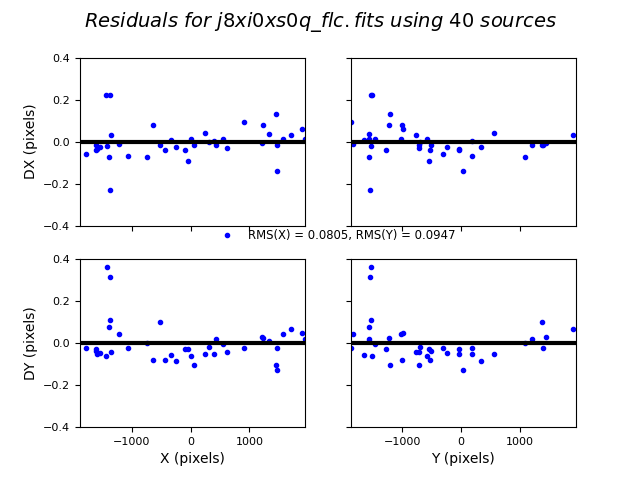

In [12]:
Image(filename='test2_residuals_j8xi0xs0q_flc.png')

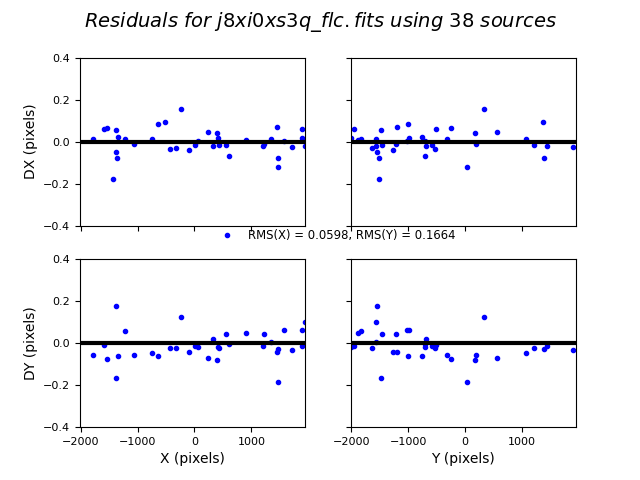

In [13]:
Image(filename='test2_residuals_j8xi0xs3q_flc.png')

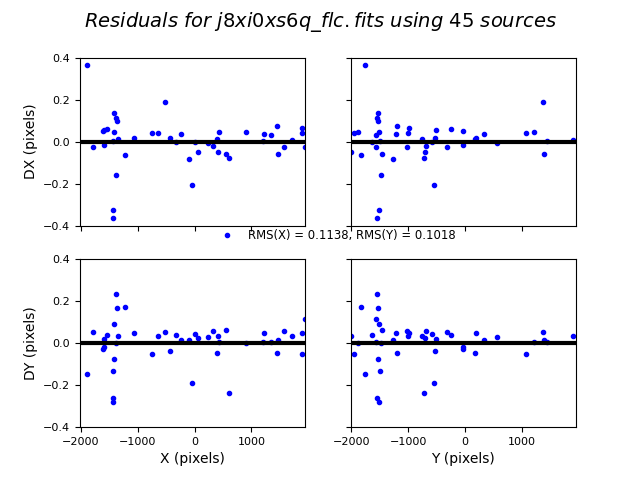

In [14]:
Image(filename='test2_residuals_j8xi0xs6q_flc.png')

In [15]:
# Inspect the shift file for Test2
shift_table = Table.read('shift814_flc_test2.txt', format='ascii.no_header', 
                       names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str18,float64,float64,float64,float64,float64,float64
j8xi0xsaq_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
j8xi0xs6q_flc.fits,-0.06,0.07,0.000,1.00003,0.11,0.10
j8xi0xs3q_flc.fits,0.05,0.15,0.001,1.00003,0.06,0.17
j8xi0xs0q_flc.fits,0.07,0.16,0.002,1.00000,0.08,0.09


## 3c. Exclude flagged pixels with `dqbits` (Test 3)

To further improve the alignment, we make use of flags in the DQ array of the FLC files. The source finding parameters in TweakReg may be modified to exclude flagged pixels when generating lists of objects in each image.

Setting the parameter `dqbits=0` will consider all non-zero pixels in the DQ mask to be “bad” pixels, and the corresponding image pixels will not be used for source finding. The default value of 'None' will turn off the use of image’s DQ array for source finding. In this case, AstroDrizzle was already run by MAST on visit 0X, and cosmic-ray flags were populated in the DQ array of the FLC frames. Since the exposures within this visit were already well aligned, the 4096 flags for cosmic rays are useful for excluding false detections.

In [16]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0, 'dqbits': 0},
                  shiftfile=True, outshifts='shift814_flc_test3.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 18:32:55.947 (03/10/2023) 


TweakReg Version 3.5.1 started at: 18:32:55.947 (03/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.26.0 


numpy Version -> 1.26.0 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	6.0
INFO:drizzlepac.tweakreg:	dqbits :	0
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweak

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:32:56.142 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:32:56.142 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173600
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:56.96 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1154 objects.


     Found 1154 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:32:57.060 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:32:57.060 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.010726
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:57.874 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 963 objects.


     Found 963 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2117


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2117


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:32:58.493 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:32:58.493 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.091646
INFO:drizzlepac.catalogs:###Source finding finished at: 18:32:59.30 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 780 objects.


     Found 780 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:32:59.394 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:32:59.394 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.106821
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:00.199 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 728 objects.


     Found 728 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1508


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1508


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:33:00.708 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:33:00.708 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173861
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:01.5 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 634 objects.


     Found 634 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:33:01.60 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:33:01.60 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.040191
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:02.405 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 561 objects.


     Found 561 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1195


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1195


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:33:02.826 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:33:02.826 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.632135
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:03.629 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 630 objects.


     Found 630 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:33:03.729 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:33:03.729 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.651426
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:04.536 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 639 objects.


     Found 639 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1269


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1269


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.4
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4141, -0.3849 with significance of 43.08 and 58 matches


Found initial X and Y shifts of 0.4141, -0.3849 with significance of 43.08 and 58 matches


INFO:drizzlepac.imgclasses:Found 50 matches for j8xi0xs6q_flc.fits...


Found 50 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0470  YSH: 0.0808    ROT: 8.193055375e-05    SCALE: 1.000016


XSH: -0.0470  YSH: 0.0808    ROT: 8.193055375e-05    SCALE: 1.000016


INFO:drizzlepac.imgclasses:FIT XRMS: 0.11       FIT YRMS: 0.068  


FIT XRMS: 0.11       FIT YRMS: 0.068  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.13       FIT MAE: 0.091  


FIT RMSE: 0.13       FIT MAE: 0.091  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  44  objects.


Final solution based on  44  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1005, -0.00293 with significance of 36.98 and 51 matches


Found initial X and Y shifts of 0.1005, -0.00293 with significance of 36.98 and 51 matches


INFO:drizzlepac.imgclasses:Found 42 matches for j8xi0xs3q_flc.fits...


Found 42 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0585  YSH: 0.1188    ROT: 0.0006466129777    SCALE: 1.000011


XSH: 0.0585  YSH: 0.1188    ROT: 0.0006466129777    SCALE: 1.000011


INFO:drizzlepac.imgclasses:FIT XRMS: 0.047      FIT YRMS: 0.068  


FIT XRMS: 0.047      FIT YRMS: 0.068  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.083      FIT MAE: 0.065  


FIT RMSE: 0.083      FIT MAE: 0.065  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-06 (deg)   RMS_DEC: 4.8e-07 (deg)


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 4.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  36  objects.


Final solution based on  36  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 36


Total # points: 36


INFO:drizzlepac.tweakutils:# of points after clipping: 36


# of points after clipping: 36


INFO:drizzlepac.tweakutils:Total # points: 36


Total # points: 36


INFO:drizzlepac.tweakutils:# of points after clipping: 36


# of points after clipping: 36


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 3.553e-15, 3.553e-15 with significance of 35.68 and 57 matches


Found initial X and Y shifts of 3.553e-15, 3.553e-15 with significance of 35.68 and 57 matches


INFO:drizzlepac.imgclasses:Found 45 matches for j8xi0xs0q_flc.fits...


Found 45 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0668  YSH: 0.1439    ROT: 0.001460272412    SCALE: 1.000004


XSH: 0.0668  YSH: 0.1439    ROT: 0.001460272412    SCALE: 1.000004


INFO:drizzlepac.imgclasses:FIT XRMS: 0.079      FIT YRMS: 0.077  


FIT XRMS: 0.079      FIT YRMS: 0.077  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.11       FIT MAE: 0.079  


FIT RMSE: 0.11       FIT MAE: 0.079  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 8.9e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 8.9e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  39  objects.


Final solution based on  39  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test3.txt


Writing out shiftfile : shift814_flc_test3.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


In [17]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test3_{}'.format(png)))
    os.rename(path, new_path)   

In this third test, TweakReg again finds ~40 matches per frame, but with spurious detections eliminated has an easier time locking onto the correct solution.  The fit residuals below all have an RMS ~0.1 pixels and the points are all clustered around dx,dy=0.

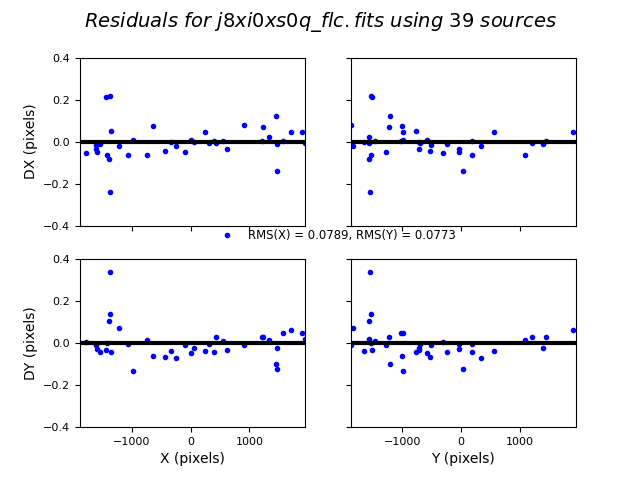

In [18]:
Image(filename='test3_residuals_j8xi0xs0q_flc.png')

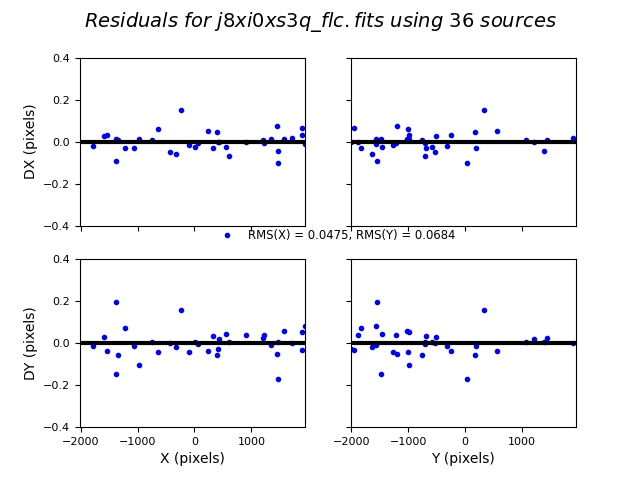

In [19]:
Image(filename='test3_residuals_j8xi0xs3q_flc.png')

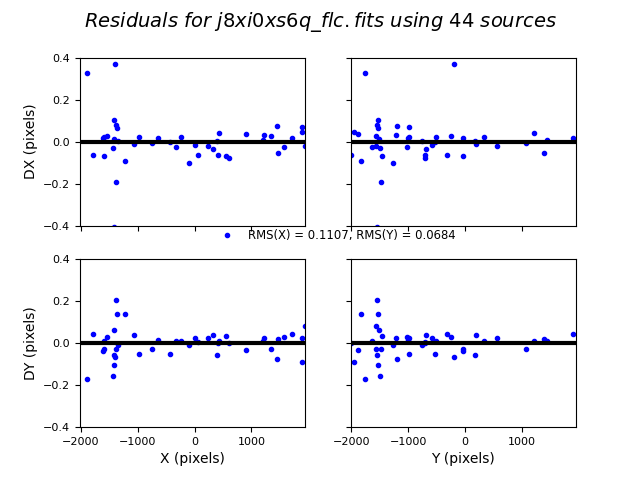

In [20]:
Image(filename='test3_residuals_j8xi0xs6q_flc.png')

In [21]:
# Inspect the shift file for Test2
shift_table = Table.read('shift814_flc_test3.txt', format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str18,float64,float64,float64,float64,float64,float64
j8xi0xsaq_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
j8xi0xs6q_flc.fits,-0.05,0.08,0.000,1.00002,0.11,0.07
j8xi0xs3q_flc.fits,0.06,0.12,0.001,1.00001,0.05,0.07
j8xi0xs0q_flc.fits,0.07,0.14,0.001,1.00000,0.08,0.08


## 3d. Rerun TweakReg to update the header WCS

Now run TweakReg with `updatehdr=True` to update the image headers with this solution.

In [22]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0, 'dqbits': 0},
                  shiftfile=False, updatehdr=True, interactive=False)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 18:33:08.579 (03/10/2023) 


TweakReg Version 3.5.1 started at: 18:33:08.579 (03/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.26.0 


numpy Version -> 1.26.0 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	6.0
INFO:drizzlepac.tweakreg:	dqbits :	0
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweak

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:33:08.975 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 18:33:08.975 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173600
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:09.810 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 1154 objects.


     Found 1154 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:33:10.031 (03/10/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 18:33:10.031 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.010726
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:10.848 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 963 objects.


     Found 963 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2117


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2117


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:33:11.388 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 18:33:11.388 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.091646
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:12.202 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 780 objects.


     Found 780 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:33:12.297 (03/10/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 18:33:12.297 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.106821
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:13.100 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 728 objects.


     Found 728 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1508


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1508


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:33:13.653 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 18:33:13.653 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.173861
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:14.457 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 634 objects.


     Found 634 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:33:14.552 (03/10/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 18:33:14.552 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.040191
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:15.348 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 561 objects.


     Found 561 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1195


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1195


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:33:15.813 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 18:33:15.813 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.632135
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:16.615 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 630 objects.


     Found 630 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:33:16.709 (03/10/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 18:33:16.709 (03/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.651426
INFO:drizzlepac.catalogs:###Source finding finished at: 18:33:17.507 (03/10/2023)
INFO:drizzlepac.catalogs:     Found 639 objects.


     Found 639 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1269


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1269


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	None
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4141, -0.3849 with significance of 43.08 and 58 matches


Found initial X and Y shifts of 0.4141, -0.3849 with significance of 43.08 and 58 matches


INFO:drizzlepac.imgclasses:Found 50 matches for j8xi0xs6q_flc.fits...


Found 50 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0470  YSH: 0.0808    ROT: 8.193055375e-05    SCALE: 1.000016


XSH: -0.0470  YSH: 0.0808    ROT: 8.193055375e-05    SCALE: 1.000016


INFO:drizzlepac.imgclasses:FIT XRMS: 0.11       FIT YRMS: 0.068  


FIT XRMS: 0.11       FIT YRMS: 0.068  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.13       FIT MAE: 0.091  


FIT RMSE: 0.13       FIT MAE: 0.091  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  44  objects.


Final solution based on  44  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...


....Updating header for 'j8xi0xs6q_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]


Processing j8xi0xs6q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]


Updating header for j8xi0xs6q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8064132539415835e-06 1.3843683930174574e-05


CD_11  CD_12: 2.8064132539415835e-06 1.3843683930174574e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3556450241068538e-05 -1.884439306981034e-06


CD_21  CD_22: 1.3556450241068538e-05 -1.884439306981034e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18742044663568 2.678764158856372


CRVAL    : 150.18742044663568 2.678764158856372


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983881173817726


Plate Scale : 0.04983881173817726


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.7516116254249


ORIENTAT : 97.7516116254249


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]


Processing j8xi0xs6q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]


Updating header for j8xi0xs6q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.952914984078232e-06 1.3395316727993499e-05


CD_11  CD_12: 2.952914984078232e-06 1.3395316727993499e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3359656001892695e-05 -1.7197268851357125e-06


CD_21  CD_22: 1.3359656001892695e-05 -1.7197268851357125e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.2160710177424 2.6749288764665793


CRVAL    : 150.2160710177424 2.6749288764665793


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925639078315062


Plate Scale : 0.04925639078315062


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.3157687160992


ORIENTAT : 97.3157687160992


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1005, -0.00293 with significance of 36.98 and 51 matches


Found initial X and Y shifts of 0.1005, -0.00293 with significance of 36.98 and 51 matches


INFO:drizzlepac.imgclasses:Found 42 matches for j8xi0xs3q_flc.fits...


Found 42 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0585  YSH: 0.1188    ROT: 0.0006466129777    SCALE: 1.000011


XSH: 0.0585  YSH: 0.1188    ROT: 0.0006466129777    SCALE: 1.000011


INFO:drizzlepac.imgclasses:FIT XRMS: 0.047      FIT YRMS: 0.068  


FIT XRMS: 0.047      FIT YRMS: 0.068  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.083      FIT MAE: 0.065  


FIT RMSE: 0.083      FIT MAE: 0.065  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-06 (deg)   RMS_DEC: 4.8e-07 (deg)


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 4.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  36  objects.


Final solution based on  36  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 36


Total # points: 36


INFO:drizzlepac.tweakutils:# of points after clipping: 36


# of points after clipping: 36


INFO:drizzlepac.tweakutils:Total # points: 36


Total # points: 36


INFO:drizzlepac.tweakutils:# of points after clipping: 36


# of points after clipping: 36


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...


....Updating header for 'j8xi0xs3q_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]


Processing j8xi0xs3q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]


Updating header for j8xi0xs3q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8065860139271647e-06 1.3843943592553937e-05


CD_11  CD_12: 2.8065860139271647e-06 1.3843943592553937e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3556694023785953e-05 -1.8845968848125405e-06


CD_21  CD_22: 1.3556694023785953e-05 -1.8845968848125405e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18824291895848 2.6785522853772803


CRVAL    : 150.18824291895848 2.6785522853772803


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049839532865849065


Plate Scale : 0.049839532865849065


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.75210830154062


ORIENTAT : 97.75210830154062


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]


Processing j8xi0xs3q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]


Updating header for j8xi0xs3q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9530889286009045e-06 1.3395568909605726e-05


CD_11  CD_12: 2.9530889286009045e-06 1.3395568909605726e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3359894600299281e-05 -1.719877317318221e-06


CD_21  CD_22: 1.3359894600299281e-05 -1.719877317318221e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.2168940230613 2.6747166783446987


CRVAL    : 150.2168940230613 2.6747166783446987


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925710337981371


Plate Scale : 0.04925710337981371


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.31626548097272


ORIENTAT : 97.31626548097272


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 3.553e-15, 3.553e-15 with significance of 35.68 and 57 matches


Found initial X and Y shifts of 3.553e-15, 3.553e-15 with significance of 35.68 and 57 matches


INFO:drizzlepac.imgclasses:Found 45 matches for j8xi0xs0q_flc.fits...


Found 45 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0668  YSH: 0.1439    ROT: 0.001460272412    SCALE: 1.000004


XSH: 0.0668  YSH: 0.1439    ROT: 0.001460272412    SCALE: 1.000004


INFO:drizzlepac.imgclasses:FIT XRMS: 0.079      FIT YRMS: 0.077  


FIT XRMS: 0.079      FIT YRMS: 0.077  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.11       FIT MAE: 0.079  


FIT RMSE: 0.11       FIT MAE: 0.079  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 8.9e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 8.9e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  39  objects.


Final solution based on  39  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...


....Updating header for 'j8xi0xs0q_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]


Processing j8xi0xs0q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]


Updating header for j8xi0xs0q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8067376076586963e-06 1.3844254155861221e-05


CD_11  CD_12: 2.8067376076586963e-06 1.3844254155861221e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3556975043729483e-05 -1.8847347050624879e-06


CD_21  CD_22: 1.3556975043729483e-05 -1.8847347050624879e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18909989241504 2.67850825015531


CRVAL    : 150.18909989241504 2.67850825015531


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04984030058889872


Plate Scale : 0.04984030058889872


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.75249651987566


ORIENTAT : 97.75249651987566


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]


Processing j8xi0xs0q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]


Updating header for j8xi0xs0q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.953242671675381e-06 1.3395870049407306e-05


CD_11  CD_12: 2.953242671675381e-06 1.3395870049407306e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3360170236724881e-05 -1.7200083484027606e-06


CD_21  CD_22: 1.3360170236724881e-05 -1.7200083484027606e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21775163855554 2.67467235958484


CRVAL    : 150.21775163855554 2.67467235958484


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0492578620802662


Plate Scale : 0.0492578620802662


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.31665414005815


ORIENTAT : 97.31665414005815


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing j8xi0xsaq_flc.fits['SCI',1]


Processing j8xi0xsaq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xsaq_flc.fits[('SCI', 1)]


Updating header for j8xi0xsaq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8064471306493e-06 1.3843493312065e-05


CD_11  CD_12: 2.8064471306493e-06 1.3843493312065e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3556270468616e-05 -1.884482582885e-06


CD_21  CD_22: 1.3556270468616e-05 -1.884482582885e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18656362602 2.6788082079829


CRVAL    : 150.18656362602 2.6788082079829


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0498373960407201


Plate Scale : 0.0498373960407201


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.7518929163394


ORIENTAT : 97.7518929163394


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing j8xi0xsaq_flc.fits['SCI',2]


Processing j8xi0xsaq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xsaq_flc.fits[('SCI', 2)]


Updating header for j8xi0xsaq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9529459067396e-06 1.3395132773726e-05


CD_11  CD_12: 2.9529459067396e-06 1.3395132773726e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3359477941339e-05 -1.7197700495717e-06


CD_21  CD_22: 1.3359477941339e-05 -1.7197700495717e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21521380392 2.6749728353476


CRVAL    : 150.21521380392 2.6749728353476


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925499166070953


Plate Scale : 0.04925499166070953


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.31604973037807


ORIENTAT : 97.31604973037807


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


# 4. Drizzle the aligned frames

Combine the aligned FLC files with AstroDrizzle. The ACS team now corrects for stable hot pixels (DQ flag=16) via the dark reference files, so these pixels can be considered 'good'. Full well saturated pixels (DQ flag=256) and warm pixels (DQ flag=64) may also be treated as good. More details on the recommended drizzle parameters for ACS may be found in [ISR 2017-02](http://www.stsci.edu/hst/acs/documents/isrs/isr1702.pdf).

In [23]:
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f814w',
                          preserve=False,
                          clean=True,
                          build=False,
                          context=False,
                          driz_sep_bits='256,64,16',
                          combine_type='median',
                          final_bits='256,64,16',
                          runfile='f814w_driz.log')

INFO:drizzlepac.util:Setting up logfile :  f814w_driz.log


Setting up logfile :  f814w_driz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: f814w_driz.log


AstroDrizzle log file: f814w_driz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 18:33:23.070 (03/10/2023)


AstroDrizzle Version 3.5.1 started at: 18:33:23.070 (03/10/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [GCC 11.4.0]
INFO:drizzlepac.astrodrizzle:3.9.18 (main, Aug 28 2023, 08:38:32) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.0 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.9.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  18:33:23.075 (03/10/2023)


==== Processing Step  Initialization  started at  18:33:23.075 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f814w_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.086567762843097
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.086567762843097
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.3236786206228584
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.3236786206228584
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.5965940631775021
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.5965940631775021
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 56.16291809082031
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 56.16291809082031
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 51.33971786499024
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 51.33971786

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20205747613429  2.6769790105254843  


CRVAL : 150.20205747613429  2.6769790105254843  


INFO:astropy.wcs.wcs:CRPIX : 2111.5  2211.0  


CRPIX : 2111.5  2211.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116107294041975e-06  1.3677915347658933e-05  


CD1_1 CD1_2  : 2.4116107294041975e-06  1.3677915347658933e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.3677915347658933e-05  -2.4116107294041975e-06  


CD2_1 CD2_2  : 1.3677915347658933e-05  -2.4116107294041975e-06  


INFO:astropy.wcs.wcs:NAXIS : 4223  4422


NAXIS : 4223  4422


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 555 Mb.


*  Estimated memory usage:  up to 555 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4223 X 4422 pixels. 


*  Output image size:       4223 X 4422 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 213 Mb. 


*  Output image file:       ~ 213 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         2


*  Cores available:         2


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 18:33:27.675 (03/10/2023)


==== Processing Step Initialization finished at 18:33:27.675 (03/10/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	False
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flc.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f814w
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	f814w_driz.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  18:33:27.683 (03/10/2023)


==== Processing Step  Static Mask  started at  18:33:27.683 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 55.593122;   rms = 11.105818;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 55.789827;   rms = 9.947657;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 50.938078;   rms = 10.826353;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 50.420948;   rms = 9.692206;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 51.294322;   rms = 10.957482;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 50.527014;   rms = 9.723391;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 50.678782;   rms = 11.627228;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 50.

==== Processing Step Static Mask finished at 18:33:32.821 (03/10/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  18:33:32.824 (03/10/2023)


==== Processing Step  Subtract Sky  started at  18:33:32.824 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	localmin
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-10-03 18:33:33.757053


***** skymatch started on 2023-10-03 18:33:33.757053


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs0q_flc.fits'


   **  Input image: 'j8xi0xs0q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs0q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs0q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs3q_flc.fits'


   **  Input image: 'j8xi0xs3q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs3q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs3q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs6q_flc.fits'


   **  Input image: 'j8xi0xs6q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs6q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs6q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs6q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs6q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xsaq_flc.fits'


   **  Input image: 'j8xi0xsaq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xsaq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xsaq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xsaq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xsaq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs0q_flc.fits


   *   Image: j8xi0xs0q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs3q_flc.fits


   *   Image: j8xi0xs3q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs6q_flc.fits


   *   Image: j8xi0xs6q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xsaq_flc.fits


   *   Image: j8xi0xsaq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits['SCI',1,2]'  --  SKY = 44.30999454897066 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits['SCI',1,2]'  --  SKY = 44.30999454897066 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


      - EXT = 'SCI',1   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


      - EXT = 'SCI',2   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits['SCI',1,2]'  --  SKY = 40.504708374745746 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits['SCI',1,2]'  --  SKY = 40.504708374745746 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits['SCI',1,2]'  --  SKY = 40.63920241135817 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits['SCI',1,2]'  --  SKY = 40.63920241135817 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits['SCI',1,2]'  --  SKY = 40.16599034416605 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits['SCI',1,2]'  --  SKY = 40.16599034416605 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs0q_flc.fits['SCI',1,2]'  --  SKY = 44.30999454897066 (brightness units)


   *   Image:   'j8xi0xs0q_flc.fits['SCI',1,2]'  --  SKY = 44.30999454897066 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


      - EXT = 'SCI',1   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


      - EXT = 'SCI',2   delta(MDRIZSKY) = 56.1629   NEW MDRIZSKY = 56.1629


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs3q_flc.fits['SCI',1,2]'  --  SKY = 40.504708374745746 (brightness units)


   *   Image:   'j8xi0xs3q_flc.fits['SCI',1,2]'  --  SKY = 40.504708374745746 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.3397   NEW MDRIZSKY = 51.3397


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs6q_flc.fits['SCI',1,2]'  --  SKY = 40.63920241135817 (brightness units)


   *   Image:   'j8xi0xs6q_flc.fits['SCI',1,2]'  --  SKY = 40.63920241135817 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


      - EXT = 'SCI',1   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


      - EXT = 'SCI',2   delta(MDRIZSKY) = 51.5102   NEW MDRIZSKY = 51.5102


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xsaq_flc.fits['SCI',1,2]'  --  SKY = 40.16599034416605 (brightness units)


   *   Image:   'j8xi0xsaq_flc.fits['SCI',1,2]'  --  SKY = 40.16599034416605 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.9104   NEW MDRIZSKY = 50.9104


INFO:stsci.skypac.utils:***** skymatch ended on 2023-10-03 18:33:40.930393


***** skymatch ended on 2023-10-03 18:33:40.930393


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:07.173340


TOTAL RUN TIME: 0:00:07.173340


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 18:33:41.424 (03/10/2023)


==== Processing Step Subtract Sky finished at 18:33:41.424 (03/10/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  18:33:41.426 (03/10/2023)


==== Processing Step  Separate Drizzle  started at  18:33:41.426 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 336, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzl

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20205747613429  2.6769790105254843  


CRVAL : 150.20205747613429  2.6769790105254843  


INFO:astropy.wcs.wcs:CRPIX : 2111.5  2211.0  


CRPIX : 2111.5  2211.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116107294041975e-06  1.3677915347658933e-05  


CD1_1 CD1_2  : 2.4116107294041975e-06  1.3677915347658933e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.3677915347658933e-05  -2.4116107294041975e-06  


CD2_1 CD2_2  : 1.3677915347658933e-05  -2.4116107294041975e-06  


INFO:astropy.wcs.wcs:NAXIS : 4223  4422


NAXIS : 4223  4422


INFO:drizzlepac.adrizzle:Executing 2 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 56.162918 to hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 51.339718 to hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.

-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


  warnings.warn(

  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_wht.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_wht.fits
Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 51.510189 to hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.910393 to hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 51.510189 to hst_10092_

-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


  warnings.warn(

  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_wht.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_wht.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 56.162918 to j8xi0xs0q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 51.339718 to j8xi0xs3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 56.162918 to j8xi0xs0q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 51.339718 to j8xi0xs3q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate

-Generating simple FITS output: j8xi0xs0q_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_single_sci.fits


-Generating simple FITS output: j8xi0xs3q_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_single_sci.fits


Writing out image to disk: j8xi0xs0q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_single_sci.fits


Writing out image to disk: j8xi0xs3q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_single_wht.fits


Writing out image to disk: j8xi0xs0q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_single_wht.fits


Writing out image to disk: j8xi0xs3q_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 51.510189 to j8xi0xs6q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.910393 to j8xi0xsaq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 51.510189 to j8xi0xs6q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 50.910393 to j8xi0xsaq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate

-Generating simple FITS output: j8xi0xs6q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_single_sci.fits


-Generating simple FITS output: j8xi0xsaq_single_sci.fits


  warnings.warn(

  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_single_sci.fits


Writing out image to disk: j8xi0xs6q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_single_sci.fits


Writing out image to disk: j8xi0xsaq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_single_wht.fits


Writing out image to disk: j8xi0xs6q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_single_wht.fits


Writing out image to disk: j8xi0xsaq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 18:33:53.815 (03/10/2023)


==== Processing Step Separate Drizzle finished at 18:33:53.815 (03/10/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  18:33:53.818 (03/10/2023)


==== Processing Step  Create Median  started at  18:33:53.818 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	median
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits' is 56.16291809082031


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits' is 56.16291809082031


INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits' is 51.33971786499024


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits' is 51.33971786499024


INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits' is 51.510189056396484


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits' is 51.510189056396484


INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits' is 50.91039276123047


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits' is 50.91039276123047


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs0q_flc.fits' is 56.16291809082031


reference sky value for image 'j8xi0xs0q_flc.fits' is 56.16291809082031


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs3q_flc.fits' is 51.33971786499024


reference sky value for image 'j8xi0xs3q_flc.fits' is 51.33971786499024


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs6q_flc.fits' is 51.510189056396484


reference sky value for image 'j8xi0xs6q_flc.fits' is 51.510189056396484


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xsaq_flc.fits' is 50.91039276123047


reference sky value for image 'j8xi0xsaq_flc.fits' is 50.91039276123047


  _combine(arrays, out, nlow, nhigh, badmasks, funcstr)

INFO:drizzlepac.createMedian:Saving output median image to: 'f814w_med.fits'


Saving output median image to: 'f814w_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 18:34:02.339 (03/10/2023)


==== Processing Step Create Median finished at 18:34:02.339 (03/10/2023)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  18:34:02.341 (03/10/2023)


==== Processing Step  Blot  started at  18:34:02.341 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 56.162918 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 56.162918 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.339718 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.339718 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.510189 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.510189 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.910393 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.910393 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 56.162918 to blotted image j8xi0xs0q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs0q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_sci1_blt.fits


Writing out image to disk: j8xi0xs0q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 56.162918 to blotted image j8xi0xs0q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs0q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_sci2_blt.fits


Writing out image to disk: j8xi0xs0q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.339718 to blotted image j8xi0xs3q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs3q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_sci1_blt.fits


Writing out image to disk: j8xi0xs3q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.339718 to blotted image j8xi0xs3q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs3q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_sci2_blt.fits


Writing out image to disk: j8xi0xs3q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.510189 to blotted image j8xi0xs6q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs6q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_sci1_blt.fits


Writing out image to disk: j8xi0xs6q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 51.510189 to blotted image j8xi0xs6q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs6q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_sci2_blt.fits


Writing out image to disk: j8xi0xs6q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.910393 to blotted image j8xi0xsaq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_sci1_blt.fits


-Generating simple FITS output: j8xi0xsaq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_sci1_blt.fits


Writing out image to disk: j8xi0xsaq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.910393 to blotted image j8xi0xsaq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_sci2_blt.fits


-Generating simple FITS output: j8xi0xsaq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_sci2_blt.fits


Writing out image to disk: j8xi0xsaq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 18:34:31.13 (03/10/2023)


==== Processing Step Blot finished at 18:34:31.13 (03/10/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  18:34:31.134 (03/10/2023)


==== Processing Step  Driz_CR  started at  18:34:31.134 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 2 parallel workers
INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs0q_sci1_crmask.fits


Creating output: j8xi0xs0q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs3q_sci1_crmask.fits


Creating output: j8xi0xs3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs0q_sci2_crmask.fits


Creating output: j8xi0xs0q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs3q_sci2_crmask.fits


Creating output: j8xi0xs3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xsaq_sci1_crmask.fits


Creating output: j8xi0xsaq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs6q_sci1_crmask.fits


Creating output: j8xi0xs6q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xsaq_sci2_crmask.fits


Creating output: j8xi0xsaq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs6q_sci2_crmask.fits


Creating output: j8xi0xs6q_sci2_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 18:34:46.798 (03/10/2023)


==== Processing Step Driz_CR finished at 18:34:46.798 (03/10/2023)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  18:34:46.813 (03/10/2023)


==== Processing Step  Final Drizzle  started at  18:34:46.813 (03/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 336, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	f814w_driz.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20205747613429  2.6769790105254843  


CRVAL : 150.20205747613429  2.6769790105254843  


INFO:astropy.wcs.wcs:CRPIX : 2111.5  2211.0  


CRPIX : 2111.5  2211.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116107294041975e-06  1.3677915347658933e-05  


CD1_1 CD1_2  : 2.4116107294041975e-06  1.3677915347658933e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.3677915347658933e-05  -2.4116107294041975e-06  


CD2_1 CD2_2  : 1.3677915347658933e-05  -2.4116107294041975e-06  


INFO:astropy.wcs.wcs:NAXIS : 4223  4422


NAXIS : 4223  4422


INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 56.162918 to hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 56.162918 to hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:dr

-Generating simple FITS output: f814w_drc_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f814w_drc_sci.fits


Writing out image to disk: f814w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f814w_drc_wht.fits


Writing out image to disk: f814w_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 18:35:31.771 (03/10/2023)


==== Processing Step Final Drizzle finished at 18:35:31.771 (03/10/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 18:35:31.775 (03/10/2023).


AstroDrizzle Version 3.5.1 is finished processing at 18:35:31.775 (03/10/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.6000 sec.


         Initialization          4.6000 sec.


INFO:drizzlepac.util:            Static Mask          5.1375 sec.


            Static Mask          5.1375 sec.


INFO:drizzlepac.util:           Subtract Sky          8.6004 sec.


           Subtract Sky          8.6004 sec.


INFO:drizzlepac.util:       Separate Drizzle          12.3885 sec.


       Separate Drizzle          12.3885 sec.


INFO:drizzlepac.util:          Create Median          8.5206 sec.


          Create Median          8.5206 sec.


INFO:drizzlepac.util:                   Blot          28.7907 sec.


                   Blot          28.7907 sec.


INFO:drizzlepac.util:                Driz_CR          15.6644 sec.


                Driz_CR          15.6644 sec.


INFO:drizzlepac.util:          Final Drizzle          44.9574 sec.


          Final Drizzle          44.9574 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          128.6596 sec.


                  Total          128.6596 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs0q_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs3q_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs6q_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xsaq_flc.fits
INFO:drizzlepac.util:Trailer file written to:  f814w_driz.log


Trailer file written to:  f814w_driz.log


# 5. Display the original FLC image and the combined DRC data

In [24]:
sci2 = fits.getdata('j8xi0xsaq_flc.fits', ('sci', 2))
sci1 = fits.getdata('j8xi0xsaq_flc.fits', ('sci', 1))

fig = plt.figure(figsize=(50, 50))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(1, 2, 1)

ax1.imshow(sci2, vmin=50, vmax=100, cmap='Greys_r', origin='lower')
ax2.imshow(sci1, vmin=50, vmax=100, cmap='Greys_r', origin='lower')

In [25]:
sci = fits.getdata('f814w_drc_sci.fits')
fig = plt.figure(figsize=(20, 20))
plt.imshow(sci, vmin=-0.01, vmax=0.1, cmap='Greys_r', origin='lower')

# Summary

TweakReg may be used to align HST images based on the position of objects in the frame. Point sources are typically used for this purpose, but compact sources such as background galaxies may also be used by increasing the value of the parameter `conv_width` in `imagefindpars`. The data quality arrays of the input calibrated frames may also be used to further improve the fits by telling TweakReg to ignore pixels with specific flags inthe DQ array via the parameter `dqbits` in `imagefindpars`. 

# About this Notebook

    Author: J. Mack, STScI WFC3 Team
    Updated: January 8, 2019